In [3]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("data_database.db")

df = pd.read_sql("SELECT * FROM data_table", conn)

print(df.head())

        Description               Unit of measure  \
0  Exports of goods  Current prices, million euro   
1  Exports of goods  Current prices, million euro   
2  Exports of goods  Current prices, million euro   
3  Exports of goods  Current prices, million euro   
4  Exports of goods  Current prices, million euro   

                                          Attributes  \
0  Exports of goods, European Union - 27 countrie...   
1  Exports of goods, Euro area (EA11-1999, EA12-2...   
2  Exports of goods, Euro area – 20 countries (fr...   
3  Exports of goods, Euro area - 19 countries  (2...   
4  Exports of goods, Euro area - 12 countries (20...   

                                               Label       2010       2011  \
0          European Union - 27 countries (from 2020)  3297061.4  3675256.8   
1  Euro area (EA11-1999, EA12-2001, EA13-2007, EA...  2739502.1  3049822.4   
2               Euro area – 20 countries (from 2023)  2776313.5  3085753.0   
3              Euro area - 19 co

### Normalization

### Z

In [167]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

time_series_columns = [str(year) for year in range(2010, 2021)]

time_series_data = df[time_series_columns].values

if np.isnan(time_series_data).any():
    print("NaN values found in time series data. Removing rows with NaN values...")
    valid_rows = ~np.isnan(time_series_data).any(axis=1)
    time_series_data = time_series_data[valid_rows]
    df = df.loc[valid_rows]

normalized_data = np.array([zscore(row, nan_policy='omit') for row in time_series_data])

valid_rows = ~np.isnan(normalized_data).any(axis=1)
if not valid_rows.all():
    print(f"Invalid rows found after normalization. Removing {np.sum(~valid_rows)} rows...")
    normalized_data = normalized_data[valid_rows]
    df = df.loc[valid_rows]

df["Normalized_Data"] = [
    ','.join(map(str, row)) for row in normalized_data
]

print(f"Z-Score normalization completed successfully. Total rows after normalization: {df.shape[0]}")

Z-Score normalization completed successfully. Total rows after normalization: 3570


### Z with smooth

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

time_series_columns = [str(year) for year in range(2010, 2021)]

time_series_data = df[time_series_columns].values

if np.isnan(time_series_data).any():
    print("NaN values found in time series data. Removing rows with NaN values...")
    valid_rows = ~np.isnan(time_series_data).any(axis=1)
    time_series_data = time_series_data[valid_rows]
    df = df.loc[valid_rows]

window_size = 3
smoothed_data = np.apply_along_axis(
    lambda row: pd.Series(row).rolling(window=window_size, min_periods=1).mean().values,
    axis=1,
    arr=time_series_data
)

normalized_data = np.array([zscore(row, nan_policy='omit') for row in smoothed_data])

valid_rows = ~np.isnan(normalized_data).any(axis=1)
if not valid_rows.all():
    print(f"Invalid rows found after normalization. Removing {np.sum(~valid_rows)} rows...")
    normalized_data = normalized_data[valid_rows]
    df = df.loc[valid_rows]

df["Normalized_Data"] = [
    ','.join(map(str, row)) for row in normalized_data
]

print(f"Z-Score normalization with smoothing completed successfully. Total rows after normalization: {df.shape[0]}")

Z-Score normalization with smoothing completed successfully. Total rows after normalization: 3332


## Culustering

### Kshape

In [300]:
from tslearn.clustering import KShape
import numpy as np

normalized_data_array = np.array(
    [list(map(float, row.split(','))) for row in df["Normalized_Data"]]
).reshape((df.shape[0], len(time_series_columns), 1))

n_clusters = 30  
kshape = KShape(n_clusters=n_clusters, verbose=True, random_state=42)

df["Cluster"] = kshape.fit_predict(normalized_data_array)

print("K-Shape clustering completed successfully.")

cluster_counts = df["Cluster"].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_counts)

0.015 --> 0.025 --> 
K-Shape clustering completed successfully.
Cluster Sizes:
Cluster
0     123
1     193
2      37
3      70
4     152
5     133
6      84
7      85
8      98
9      42
10     45
11     72
12     47
13    111
14    190
15    206
16    150
17    181
18    120
19    180
20    132
21     60
22    127
23    203
24    159
25    184
26    118
27     62
28    111
29     95
Name: count, dtype: int64


### Kmeans dtw

In [356]:
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

normalized_data_array = np.array(
    [list(map(float, row.split(','))) for row in df["Normalized_Data"]]
).reshape((df.shape[0], len(time_series_columns), 1)) 


n_clusters = 15  
print(f"Clustering with K-Means (DTW) into {n_clusters} clusters...")

kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False, random_state=42)

df["Cluster"] = kmeans_dtw.fit_predict(normalized_data_array)

print("Clustering with K-Means (DTW) completed successfully.")

cluster_counts = df["Cluster"].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_counts)



Clustering with K-Means (DTW) into 15 clusters...
Clustering with K-Means (DTW) completed successfully.
Cluster Sizes:
Cluster
0     155
1     114
2     389
3     130
4     164
5     443
6     150
7     151
8     797
9     152
10    244
11    164
12    105
13     79
14     95
Name: count, dtype: int64


### Kmeans

In [80]:
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

normalized_data_array = np.array(
    [list(map(float, row.split(','))) for row in df["Normalized_Data"]]
).reshape((df.shape[0], len(time_series_columns), 1)) 

n_clusters = 1  
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True, random_state=42)

df["Cluster"] = kmeans.fit_predict(normalized_data_array)

print("K-Means clustering with Euclidean distance completed successfully.")

cluster_counts = df["Cluster"].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_counts)

10.150 --> 7.640 --> 7.640 --> 
K-Means clustering with Euclidean distance completed successfully.
Cluster Sizes:
Cluster
0    3332
Name: count, dtype: int64


### Save

In [503]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")
output_filename = f"clustered_data_{timestamp}.csv"

df.to_csv(output_filename, index=False)

print(f"DataFrame saved to {output_filename}")

DataFrame saved to clustered_data_20241201-034553.csv


### Cluster info

In [19]:
from sklearn.metrics import silhouette_score
import numpy as np

normalized_data_flat = normalized_data_array.reshape((normalized_data_array.shape[0], -1))

sil_score = silhouette_score(normalized_data_flat, df["Cluster"], metric="euclidean")
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.184


In [20]:
for cluster_id in range(n_clusters):
    cluster_data = normalized_data_array[df["Cluster"] == cluster_id]
    mean_trend = cluster_data.mean(axis=0)
    intra_variance = np.mean([np.linalg.norm(series - mean_trend) for series in cluster_data])
    print(f"Cluster {cluster_id} Intra-Cluster Variance: {intra_variance:.3f}")

Cluster 0 Intra-Cluster Variance: 0.870
Cluster 1 Intra-Cluster Variance: 1.687
Cluster 2 Intra-Cluster Variance: 1.638
Cluster 3 Intra-Cluster Variance: 1.953
Cluster 4 Intra-Cluster Variance: 2.204
Cluster 5 Intra-Cluster Variance: 1.585
Cluster 6 Intra-Cluster Variance: 1.783
Cluster 7 Intra-Cluster Variance: 1.274
Cluster 8 Intra-Cluster Variance: 0.868
Cluster 9 Intra-Cluster Variance: 1.890


### Trial stuff

In [1054]:
from tslearn.metrics import dtw
import numpy as np
import random
import matplotlib.pyplot as plt

def parse_attributes(attributes):
    return set(attr.strip().lower() for attr in attributes.split(','))

def has_common_attributes(attrs1, attrs2):
    return bool(attrs1.intersection(attrs2))

def find_nearest_neighbor_dtw(df, random_row_index, similarity_threshold=0.2):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        ~cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if not candidates.empty:
        candidate_series = np.array([
            list(map(float, row.split(','))) for row in candidates["Normalized_Data"]
        ])

        distances = np.array([dtw(random_series, candidate) for candidate in candidate_series])

        nearest_idx = np.argmin(distances)
        nearest_distance = distances[nearest_idx]
        if nearest_distance < similarity_threshold:
            nearest_row = candidates.iloc[nearest_idx]
            return nearest_row, candidates.index[nearest_idx], nearest_distance

    return None, None, None

max_attempts = 20
attempts = 0

while attempts < max_attempts:
    random_row_index = random.randint(0, len(df) - 1)
    nearest_row, nearest_index, similarity_score = find_nearest_neighbor_dtw(df, random_row_index)

    if nearest_row is not None:
        print(f"\nSimilarity Score (DTW Distance): {similarity_score:.4f}")


        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        plt.figure(figsize=(8, 4)) 


        plt.subplot(1, 2, 1)
        plt.plot(years, random_series_absolute, label="Random Row", color="blue", marker="o")
        plt.title("Random Row")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(years, nearest_series_absolute, label="Nearest Neighbor", color="orange", marker="o")
        plt.title("Nearest Neighbor")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
        

        print("Random Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"Attempt {attempts +1}")
    
    attempts += 1



if attempts == max_attempts:
    print("No suitable nearest neighbor found after maximum attempts.")

Attempt 1
Attempt 2
Attempt 3
Attempt 4
Attempt 5
Attempt 6
Attempt 7
Attempt 8
Attempt 9
Attempt 10
Attempt 11
Attempt 12
Attempt 13
Attempt 14
Attempt 15
Attempt 16
Attempt 17
Attempt 18
Attempt 19
Attempt 20
No suitable nearest neighbor found after maximum attempts.


### SDTW

Processing Random Row Index: 1257
Similarity Score (Soft-DTW Distance): -13.3197


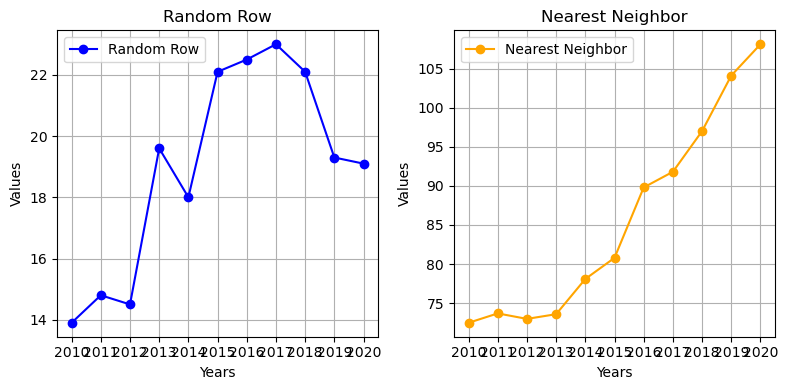

Random Row Metadata:
Description        Employment in Professional, scientific and tec...
Unit of measure                                     Thousand persons
Label                                                Moravskoslezsko
Name: 1257, dtype: object

Nearest Neighbor Metadata:
Description        Employment in Education
Unit of measure           Thousand persons
Label                       Batı Karadeniz
Name: 2286, dtype: object


In [99]:
from tslearn.metrics import soft_dtw
import numpy as np
import random
import matplotlib.pyplot as plt

def parse_attributes(attributes):
    return set(attr.strip().lower() for attr in attributes.split(','))

def has_common_attributes(attrs1, attrs2):
    return bool(attrs1.intersection(attrs2))

def find_nearest_neighbor_soft_dtw(df, random_row_index, gamma=1.0, similarity_threshold=5.0):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        ~cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if not candidates.empty:
        candidate_series = np.array([
            list(map(float, row.split(','))) for row in candidates["Normalized_Data"]
        ])

        distances = np.array([soft_dtw(random_series, candidate, gamma=gamma) for candidate in candidate_series])

        valid_indices = np.where(distances <= similarity_threshold)[0]
        if valid_indices.size > 0:
            nearest_idx = valid_indices[np.argmin(distances[valid_indices])]
            nearest_distance = distances[nearest_idx]
            nearest_row = candidates.iloc[nearest_idx]
            return nearest_row, candidates.index[nearest_idx], nearest_distance

    return None, None, None

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    similarity_threshold = -13
    nearest_row, nearest_index, similarity_score = find_nearest_neighbor_soft_dtw(
        df, random_row_index, gamma=1.0, similarity_threshold=similarity_threshold
    )

    if nearest_row is not None:
        print(f"Similarity Score (Soft-DTW Distance): {similarity_score:.4f}")
        
        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(years, random_series_absolute, label="Random Row", color="blue", marker="o")
        plt.title("Random Row")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(years, nearest_series_absolute, label="Nearest Neighbor", color="orange", marker="o")
        plt.title("Nearest Neighbor")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("Random Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

### Twed

Processing Random Row Index: 1076
Similarity Score (TWED Distance): 0.4180


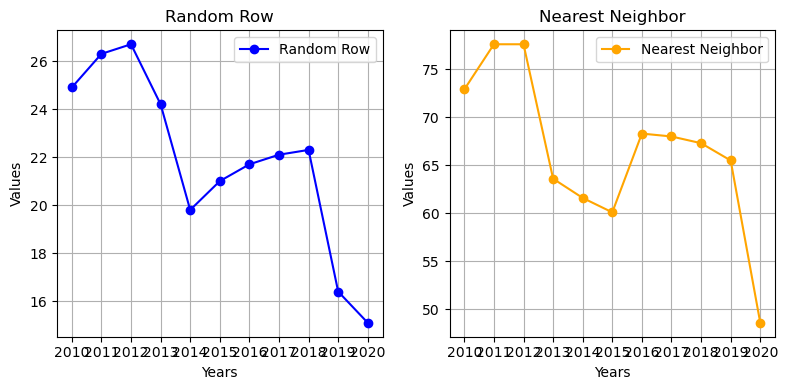

Random Row Metadata:
Description        Employment in Financial and insurance activities
Unit of measure                                    Thousand persons
Label                                               Alföld és Észak
Name: 1076, dtype: object

Nearest Neighbor Metadata:
Description        Employment in Administrative and support servi...
Unit of measure                                     Thousand persons
Label                                                 Sachsen-Anhalt
Name: 1654, dtype: object


In [132]:
import numpy as np
import random
import matplotlib.pyplot as plt

def parse_attributes(attributes):
    return set(attr.strip().lower() for attr in attributes.split(','))

def has_common_attributes(attrs1, attrs2):
    return bool(attrs1.intersection(attrs2))

def find_nearest_neighbor_twed(df, random_row_index, lambda_param=0.5, nu=0.1):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        ~cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if not candidates.empty:
        candidate_series = np.array([
            list(map(float, row.split(','))) for row in candidates["Normalized_Data"]
        ])

        distances = np.array([twed(random_series, candidate, lambda_param=lambda_param, nu=nu) for candidate in candidate_series])

        nearest_idx = np.argmin(distances)
        nearest_distance = distances[nearest_idx]
        nearest_row = candidates.iloc[nearest_idx]
        return nearest_row, candidates.index[nearest_idx], nearest_distance

    return None, None, None

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    lambda_param = 0.5  
    nu = 0.1  

    nearest_row, nearest_index, similarity_score = find_nearest_neighbor_twed(
        df, random_row_index, lambda_param=lambda_param, nu=nu
    )

    if nearest_row is not None:
        print(f"Similarity Score (TWED Distance): {similarity_score:.4f}")

        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(years, random_series_absolute, label="Random Row", color="blue", marker="o")
        plt.title("Random Row")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(years, nearest_series_absolute, label="Nearest Neighbor", color="orange", marker="o")
        plt.title("Nearest Neighbor")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("Random Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

### Matrixes

Processing Random Row Index: 1415
Similarity Score (Matrix Profile Minimum Distance): 0.5897


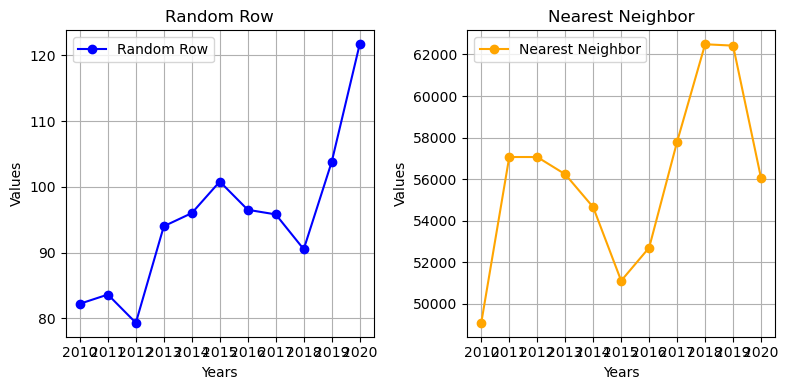

Random Row Metadata:
Description        Employment in Professional, scientific and tec...
Unit of measure                                     Thousand persons
Label                                             Közép-Magyarország
Name: 1415, dtype: object

Nearest Neighbor Metadata:
Description                    Imports of goods
Unit of measure    Current prices, million euro
Label                                   Finland
Name: 71, dtype: object


In [143]:
import stumpy
import numpy as np
import random
import matplotlib.pyplot as plt

def parse_attributes(attributes):
    return set(attr.strip().lower() for attr in attributes.split(','))

def has_common_attributes(attrs1, attrs2):
    return bool(attrs1.intersection(attrs2))

def find_nearest_neighbor_matrix_profile(df, random_row_index, window_size=11):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        ~cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if not candidates.empty:
        best_match = None
        best_distance = float('inf')
        best_candidate_index = None

        for candidate_index, candidate_row in candidates.iterrows():
            candidate_series = np.array(list(map(float, candidate_row["Normalized_Data"].split(','))))

            matrix_profile = stumpy.mass(random_series, candidate_series)
            min_distance = np.min(matrix_profile)

            if min_distance < best_distance:
                best_distance = min_distance
                best_match = candidate_row
                best_candidate_index = candidate_index

        return best_match, best_candidate_index, best_distance

    return None, None, None

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    window_size = 11 

    nearest_row, nearest_index, similarity_score = find_nearest_neighbor_matrix_profile(
        df, random_row_index, window_size=window_size
    )

    if nearest_row is not None:
        print(f"Similarity Score (Matrix Profile Minimum Distance): {similarity_score:.4f}")

        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(years, random_series_absolute, label="Random Row", color="blue", marker="o")
        plt.title("Random Row")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(years, nearest_series_absolute, label="Nearest Neighbor", color="orange", marker="o")
        plt.title("Nearest Neighbor")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("Random Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

### EDr

Processing Random Row Index: 2274
Similarity Score (EDR Distance): 0.0000


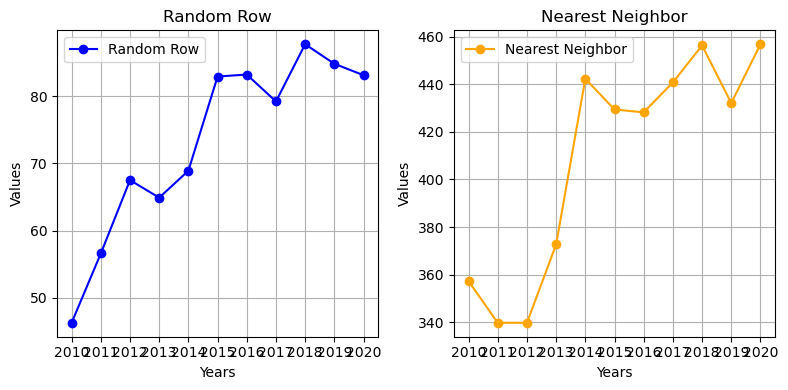

Random Row Metadata:
Description          Employment in Education
Unit of measure             Thousand persons
Label              Bursa, Eskişehir, Bilecik
Name: 2274, dtype: object

Nearest Neighbor Metadata:
Description        Employment in Manufacturing
Unit of measure               Thousand persons
Label                             Batı Anadolu
Name: 564, dtype: object


In [194]:
import numpy as np
import random
import matplotlib.pyplot as plt

def parse_attributes(attributes):
    return set(attr.strip().lower() for attr in attributes.split(','))

def has_common_attributes(attrs1, attrs2):
    return bool(attrs1.intersection(attrs2))

def find_nearest_neighbor_edr(df, random_row_index, epsilon=0.1):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if not candidates.empty:
        candidate_series = np.array([
            list(map(float, row.split(','))) for row in candidates["Normalized_Data"]
        ])

        distances = np.array([edr(random_series, candidate, epsilon) for candidate in candidate_series])

        nearest_idx = np.argmin(distances)
        nearest_distance = distances[nearest_idx]
        nearest_row = candidates.iloc[nearest_idx]
        return nearest_row, candidates.index[nearest_idx], nearest_distance

    return None, None, None

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    epsilon = 1 

    nearest_row, nearest_index, similarity_score = find_nearest_neighbor_edr(
        df, random_row_index, epsilon=epsilon
    )

    if nearest_row is not None:
        print(f"Similarity Score (EDR Distance): {similarity_score:.4f}")

        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(years, random_series_absolute, label="Random Row", color="blue", marker="o")
        plt.title("Random Row")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(years, nearest_series_absolute, label="Nearest Neighbor", color="orange", marker="o")
        plt.title("Nearest Neighbor")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("Random Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

### WDT

Processing Random Row Index: 315
Similarity Score (Weighted DTW Distance): 1.9025


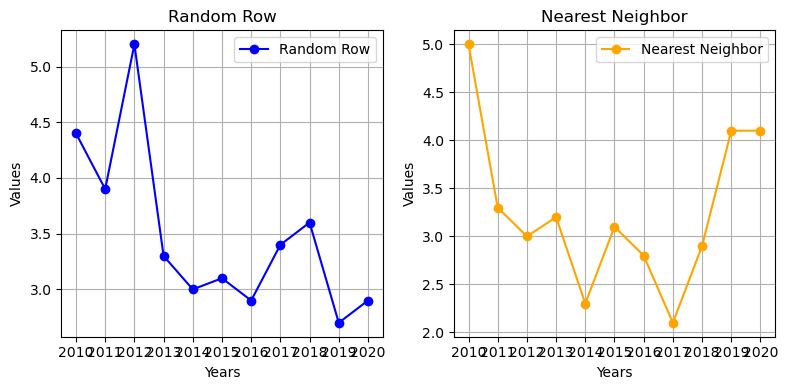

Random Row Metadata:
Description        Employment in Manufacturing
Unit of measure               Thousand persons
Label                            Voreio Aigaio
Name: 315, dtype: object

Nearest Neighbor Metadata:
Description        Employment in Arts, entertainment and recreation
Unit of measure                                    Thousand persons
Label                                                       Drenthe
Name: 2836, dtype: object


In [170]:
from tslearn.metrics import dtw
import numpy as np
import random
import matplotlib.pyplot as plt

def weighted_dtw(series1, series2, weights):
    distances = np.array([(series1[i] - series2[i])**2 * weights[i] for i in range(len(series1))])
    return np.sqrt(np.sum(distances))

def find_nearest_neighbor_weighted_dtw(df, random_row_index, weights):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        ~cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if not candidates.empty:
        candidate_series = np.array([
            list(map(float, row.split(','))) for row in candidates["Normalized_Data"]
        ])

        distances = np.array([weighted_dtw(random_series, candidate, weights) for candidate in candidate_series])

        nearest_idx = np.argmin(distances)
        nearest_distance = distances[nearest_idx]
        nearest_row = candidates.iloc[nearest_idx]
        return nearest_row, candidates.index[nearest_idx], nearest_distance

    return None, None, None

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    weights = np.array([1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])  

    nearest_row, nearest_index, similarity_score = find_nearest_neighbor_weighted_dtw(
        df, random_row_index, weights=weights
    )

    if nearest_row is not None:
        print(f"Similarity Score (Weighted DTW Distance): {similarity_score:.4f}")

        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(years, random_series_absolute, label="Random Row", color="blue", marker="o")
        plt.title("Random Row")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(years, nearest_series_absolute, label="Nearest Neighbor", color="orange", marker="o")
        plt.title("Nearest Neighbor")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("Random Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

### combination

Processing Random Row Index: 991
Selected Method: sdtw
Scores by Method:
  sdtw: -11.9882
  edr_float: 13.3525
  w_dtw_float: 1.1918
  twed_float: 1.4205


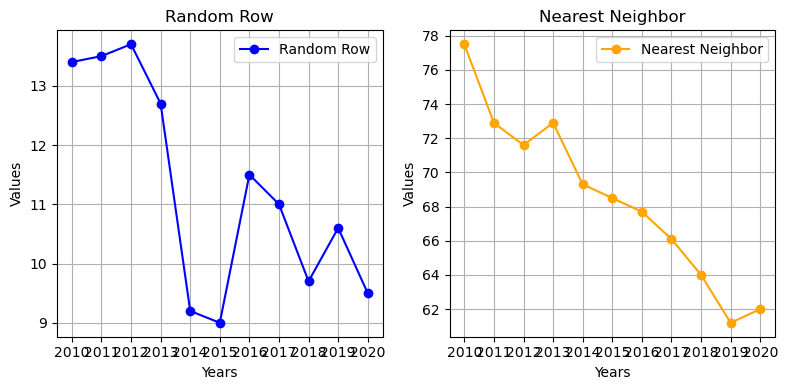

Random Row Metadata:
Description        Employment in Financial and insurance activities
Unit of measure                                    Thousand persons
Label                                                        Aragón
Name: 991, dtype: object

Nearest Neighbor Metadata:
Description        Employment in Manufacturing
Unit of measure               Thousand persons
Label                               Sydsverige
Name: 529, dtype: object


In [400]:
from scipy.stats import linregress

def calculate_trend(series):
    x = np.arange(len(series))
    slope, _, _, _, _ = linregress(x, series)
    return slope

def is_opposite_trend(series1, series2):
    trend1 = calculate_trend(series1)
    trend2 = calculate_trend(series2)
    return trend1 * trend2 < 0 

def relative_magnitude_difference(series1, series2, threshold=0.5):
    mean1, mean2 = np.mean(series1), np.mean(series2)
    return abs(mean1 - mean2) / max(mean1, mean2) <= threshold

def are_peaks_aligned(series1, series2, tolerance=2):
    peaks1 = np.argsort(series1)[-3:]  
    peaks2 = np.argsort(series2)[-3:]  
    return all(abs(p1 - p2) <= tolerance for p1, p2 in zip(peaks1, peaks2))

def find_nearest_neighbor_with_heuristics(df, random_row_index, weights=None):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        ~cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if candidates.empty:
        return None, None, None, None

    best_candidate = None
    best_index = None
    selected_method = None
    best_overall_score = float("inf")
    individual_scores = {}

    for candidate_index, candidate_row in candidates.iterrows():
        candidate_series = np.array(list(map(float, candidate_row["Normalized_Data"].split(','))))

        scores = {
            "sdtw": soft_dtw_score(random_series, candidate_series),
            "edr_float": edr_float(random_series, candidate_series, epsilon=0.1),
            "w_dtw_float": weighted_dtw_float(random_series, candidate_series, weights=[1] * len(random_series)),
            "twed_float": twed_float(random_series, candidate_series)
        }

        if is_opposite_trend(random_series, candidate_series):
            continue
        if not relative_magnitude_difference(random_series, candidate_series, threshold=0.5):
            continue
        if not are_peaks_aligned(random_series, candidate_series, tolerance=2):
            continue 
        overall_score = sum(scores.values())
        if overall_score < best_overall_score:
            best_overall_score = overall_score
            best_candidate = candidate_row
            best_index = candidate_index
            selected_method = min(scores, key=scores.get) 
            individual_scores = scores

    return best_candidate, best_index, selected_method, individual_scores

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    weights = np.array([1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]) 

    nearest_row, nearest_index, selected_method, scores = find_nearest_neighbor_with_heuristics(df, random_row_index, weights=weights)

    if nearest_row is not None:
        print(f"Selected Method: {selected_method}")
        print("Scores by Method:")
        for method, score in scores.items():
            print(f"  {method}: {score:.4f}")

        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(years, random_series_absolute, label="Random Row", color="blue", marker="o")
        plt.title("Random Row")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(years, nearest_series_absolute, label="Nearest Neighbor", color="orange", marker="o")
        plt.title("Nearest Neighbor")
        plt.xlabel("Years")
        plt.ylabel("Values")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("Random Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

### good idea (will likely stick with some form of this)

Processing Random Row Index: 3282

Selected Similarity Method: sdtw
Scores by Method:
  sdtw: -13.6766
  edr_float: 3.5560
  w_dtw_float: 0.1302
  twed_float: 0.0169


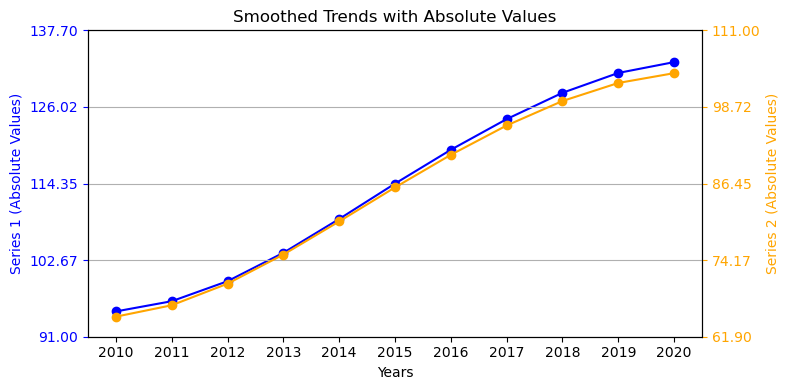


========== Random Row Metadata ==========
Description: Human resources in science and technology
Unit of Measure: Thousand persons
Label: Trøndelag
Attributes: Human resources in science and technology, Trøndelag
Trend: Increasing

========== Nearest Neighbor Metadata ==========
Description: Employment in Professional, scientific and technical activities
Unit of Measure: Thousand persons
Label: Batı Anadolu
Attributes: Employment in Professional, scientific and technical activities, Batı Anadolu
Trend: Increasing

========== Summary ==========
Selected Method: sdtw
Similarity Scores:
  sdtw: -13.6766
  edr_float: 3.5560
  w_dtw_float: 0.1302
  twed_float: 0.0169


In [501]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter1d

def parse_attributes(attributes):
    return set(attr.strip().lower() for attr in attributes.split(','))

def has_common_attributes(attrs1, attrs2):
    return bool(attrs1.intersection(attrs2))

def calculate_trend(series):
    x = np.arange(len(series))
    slope, _, _, _, _ = linregress(x, series)
    return slope

def is_opposite_trend(series1, series2):
    trend1 = calculate_trend(series1)
    trend2 = calculate_trend(series2)
    return trend1 * trend2 < 0

def soft_dtw_score(series1, series2, gamma=1.0):
    from tslearn.metrics import soft_dtw
    return soft_dtw(series1, series2, gamma=gamma)

def edr_float(S1, S2, epsilon=0.1):
    n, m = len(S1), len(S2)
    dp = np.zeros((n + 1, m + 1), dtype=float)

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(S1[i - 1] - S2[j - 1]) / epsilon
            dp[i][j] = min(dp[i - 1][j - 1] + cost, dp[i - 1][j] + 1, dp[i][j - 1] + 1)

    return dp[n][m]

def weighted_dtw_float(series1, series2, weights):
    distances = np.array([(series1[i] - series2[i])**2 * weights[i] for i in range(len(series1))])
    return np.sqrt(np.sum(distances))

def twed_float(S1, S2, lambda_param=0.5, nu=0.1):
    n, m = len(S1), len(S2)
    dp = np.full((n + 1, m + 1), np.inf, dtype=float)
    dp[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (S1[i - 1] - S2[j - 1])**2
            dp[i][j] = min(
                dp[i - 1][j - 1] + cost + nu * abs(i - j),
                dp[i - 1][j] + lambda_param,
                dp[i][j - 1] + lambda_param
            )

    return dp[n][m]

def find_nearest_neighbor_with_heuristics(df, random_row_index, weights=None):
    random_row = df.iloc[random_row_index]
    random_cluster = random_row["Cluster"]
    random_attributes = parse_attributes(random_row["Attributes"])
    random_series_absolute = np.array([random_row[str(year)] for year in range(2010, 2021)], dtype=float)
    random_series_normalized = np.array(list(map(float, random_row["Normalized_Data"].split(','))))

    cluster_data = df[(df["Cluster"] == random_cluster) & (df.index != random_row_index)]

    candidates = cluster_data[
        ~cluster_data["Attributes"].apply(lambda x: has_common_attributes(random_attributes, parse_attributes(x)))
    ]

    if candidates.empty:
        return None, None, None, None

    best_candidate = None
    best_index = None
    selected_method = None
    best_overall_score = float("inf")
    individual_scores = {}

    for candidate_index, candidate_row in candidates.iterrows():
        candidate_series_absolute = np.array([candidate_row[str(year)] for year in range(2010, 2021)], dtype=float)
        candidate_series_normalized = np.array(list(map(float, candidate_row["Normalized_Data"].split(','))))

        scores = {
            "sdtw": soft_dtw_score(random_series_normalized, candidate_series_normalized),
            "edr_float": edr_float(random_series_normalized, candidate_series_normalized, epsilon=0.1),
            "w_dtw_float": weighted_dtw_float(random_series_normalized, candidate_series_normalized, weights=[1] * len(random_series_normalized)),
            "twed_float": twed_float(random_series_normalized, candidate_series_normalized)
        }

        if is_opposite_trend(random_series_absolute, candidate_series_absolute):
            continue

        overall_score = sum(scores.values())
        if overall_score < best_overall_score:
            best_overall_score = overall_score
            best_candidate = candidate_row
            best_index = candidate_index
            selected_method = min(scores, key=scores.get)
            individual_scores = scores

    return best_candidate, best_index, selected_method, individual_scores

def smooth_series(series, sigma=1):
    return gaussian_filter1d(series, sigma=sigma)

def plot_smoothed_with_absolute_values(series1, series2, absolute1, absolute2, years, color1="blue", color2="orange", sigma=1):
    series1_smoothed = smooth_series(series1, sigma=sigma)
    series2_smoothed = smooth_series(series2, sigma=sigma)

    fig, ax1 = plt.subplots(figsize=(8, 4))

    ax1.plot(years, series1_smoothed, label="Smoothed (Series 1)", color=color1, marker="o")
    ax1.set_xlabel("Years")
    ax1.set_ylabel("Series 1 (Absolute Values)", color=color1)
    ax1.tick_params(axis='y', colors=color1)
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.plot(years, series2_smoothed, label="Smoothed (Series 2)", color=color2, marker="o")
    ax2.set_ylabel("Series 2 (Absolute Values)", color=color2)
    ax2.tick_params(axis='y', colors=color2)
    ax2.set_ylim(0, 1)

    def scale_to_absolute1(value):
        return value * (absolute1.max() - absolute1.min()) + absolute1.min()

    def scale_to_absolute2(value):
        return value * (absolute2.max() - absolute2.min()) + absolute2.min()

    ax1_ticks = np.linspace(0, 1, 5)
    ax2_ticks = np.linspace(0, 1, 5)

    ax1.set_yticks(ax1_ticks)
    ax1.set_yticklabels([f"{scale_to_absolute1(tick):.2f}" for tick in ax1_ticks])
    ax2.set_yticks(ax2_ticks)
    ax2.set_yticklabels([f"{scale_to_absolute2(tick):.2f}" for tick in ax2_ticks])

    plt.title("Smoothed Trends with Absolute Values")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    weights = np.array([1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])

    nearest_row, nearest_index, selected_method, scores = find_nearest_neighbor_with_heuristics(df, random_row_index, weights=weights)

    if nearest_row is not None:
        print(f"\nSelected Similarity Method: {selected_method}")
        print("Scores by Method:")
        for method, score in scores.items():
            print(f"  {method}: {score:.4f}")

        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = np.array([df.loc[random_row_index, str(year)] for year in years], dtype=float)
        nearest_series_absolute = np.array([df.loc[nearest_index, str(year)] for year in years], dtype=float)

        normalized_series1 = (random_series_absolute - random_series_absolute.min()) / (random_series_absolute.max() - random_series_absolute.min())
        normalized_series2 = (nearest_series_absolute - nearest_series_absolute.min()) / (nearest_series_absolute.max() - nearest_series_absolute.min())

        plot_smoothed_with_absolute_values(normalized_series1, normalized_series2, random_series_absolute, nearest_series_absolute, years, sigma=2)

        print("\n========== Random Row Metadata ==========")
        print(f"Description: {df.loc[random_row_index, 'Description']}")
        print(f"Unit of Measure: {df.loc[random_row_index, 'Unit of measure']}")
        print(f"Label: {df.loc[random_row_index, 'Label']}")
        print(f"Attributes: {df.loc[random_row_index, 'Attributes']}")
        print(f"Trend: {'Increasing' if calculate_trend(random_series_absolute) > 0 else 'Decreasing'}")

        print("\n========== Nearest Neighbor Metadata ==========")
        print(f"Description: {nearest_row['Description']}")
        print(f"Unit of Measure: {nearest_row['Unit of measure']}")
        print(f"Label: {nearest_row['Label']}")
        print(f"Attributes: {nearest_row['Attributes']}")
        print(f"Trend: {'Increasing' if calculate_trend(nearest_series_absolute) > 0 else 'Decreasing'}")

        print("\n========== Summary ==========")
        print(f"Selected Method: {selected_method}")
        print("Similarity Scores:")
        for method, score in scores.items():
            print(f"  {method}: {score:.4f}")

        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

### good simple idea

Processing Random Row Index: 2148
Selected Row Index: 3038
Euclidean Distance: 0.5975


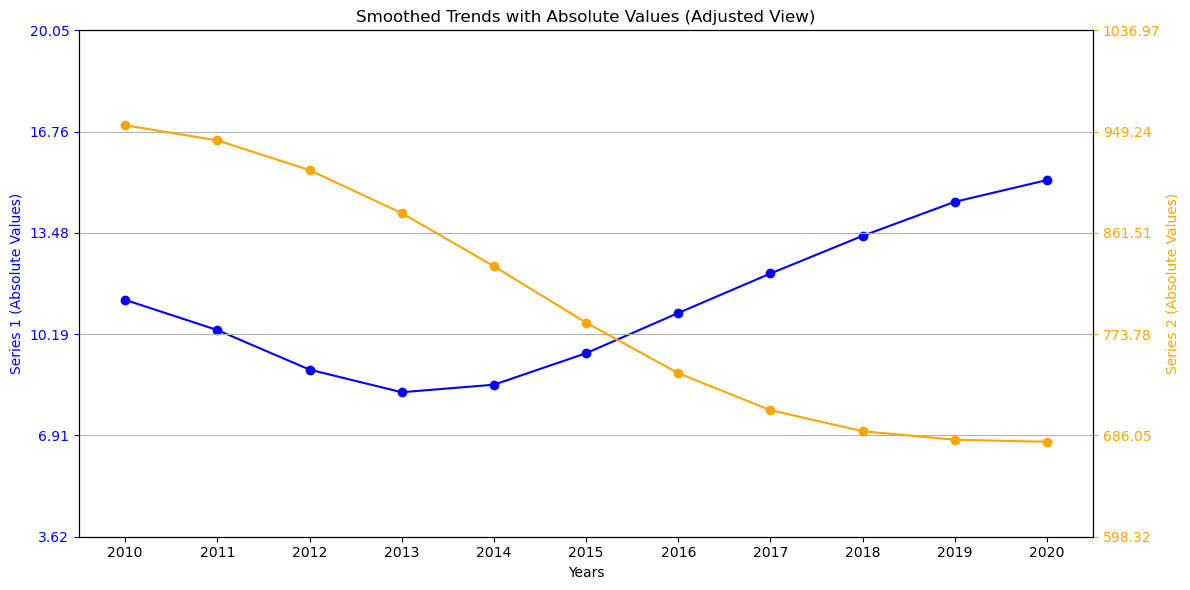


Random Row Metadata:
Description        Employment in Education
Unit of measure           Thousand persons
Label                              Drenthe
Name: 2148, dtype: object

Nearest Neighbor Metadata:
Description        Human resources in science and technology
Unit of measure                             Thousand persons
Label                                                Sachsen
Name: 3038, dtype: object


In [349]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def euclidean_distance(series1, series2):
    return np.sqrt(np.sum((series1 - series2) ** 2))

def is_within_threshold(series1, series2, start_end_threshold=0.25, point_threshold=0.50):
    
    range1 = abs(series1.max() - series1.min()) 
    start_diff = abs(series1[0] - series2[0]) 
    end_diff = abs(series1[-1] - series2[-1])  

    if start_diff > range1 * start_end_threshold or end_diff > range1 * start_end_threshold:
        return False

    point_differences = np.abs(series1 - series2)
    if np.any(point_differences > range1 * point_threshold):
        return False

    return True

def parse_attributes(attributes):
    return set(attr.strip().lower() for attr in attributes.split(','))

def has_common_attributes(attrs1, attrs2):
    return bool(attrs1.intersection(attrs2))

def find_nearest_neighbor_with_enhanced_rules(df, random_row_index, start_end_threshold=0.25, point_threshold=0.50):
    random_row = df.iloc[random_row_index]
    random_series_normalized = np.array(list(map(float, random_row["Normalized_Data"].split(','))))
    random_attributes = parse_attributes(random_row["Attributes"])

    best_candidate = None
    best_index = None
    best_distance = float("inf")

    for i, row in df.iterrows():
        if i == random_row_index:
            continue

        candidate_series_normalized = np.array(list(map(float, row["Normalized_Data"].split(','))))
        candidate_attributes = parse_attributes(row["Attributes"])

        if has_common_attributes(random_attributes, candidate_attributes):
            continue

        if not is_within_threshold(
            random_series_normalized,
            candidate_series_normalized,
            start_end_threshold=start_end_threshold,
            point_threshold=point_threshold
        ):
            continue

        distance = euclidean_distance(random_series_normalized, candidate_series_normalized)

        if distance < best_distance:
            best_distance = distance
            best_candidate = row
            best_index = i

    return best_candidate, best_index, best_distance

def smooth_series(series, sigma=2):
    return gaussian_filter1d(series, sigma=sigma)

def plot_smoothed_with_absolute_values(series1, series2, absolute1, absolute2, years, color1="blue", color2="orange", sigma=2):
    
    series1_smoothed = smooth_series(series1, sigma=sigma)
    series2_smoothed = smooth_series(series2, sigma=sigma)

    all_smoothed = np.concatenate([series1_smoothed, series2_smoothed])
    y_min, y_max = all_smoothed.min(), all_smoothed.max()
    padding = 0.30 * (y_max - y_min) 
    y_min, y_max = y_min - padding, y_max + padding

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(years, series1_smoothed, label="Normalized (Series 1)", color=color1, marker="o")
    ax1.set_xlabel("Years")
    ax1.set_ylabel("Series 1 (Absolute Values)", color=color1)
    ax1.tick_params(axis="y", colors=color1)
    ax1.set_ylim(y_min, y_max) 

    ax2 = ax1.twinx()
    ax2.plot(years, series2_smoothed, label="Normalized (Series 2)", color=color2, marker="o")
    ax2.set_ylabel("Series 2 (Absolute Values)", color=color2)
    ax2.tick_params(axis="y", colors=color2)
    ax2.set_ylim(y_min, y_max) 

    def scale_to_absolute1(value):
        return value * (absolute1.max() - absolute1.min()) + absolute1.min()

    def scale_to_absolute2(value):
        return value * (absolute2.max() - absolute2.min()) + absolute2.min()

    ax1_ticks = np.linspace(y_min, y_max, 6)
    ax2_ticks = np.linspace(y_min, y_max, 6)
    ax1.set_yticks(ax1_ticks)
    ax1.set_yticklabels([f"{scale_to_absolute1(tick):.2f}" for tick in ax1_ticks])
    ax2.set_yticks(ax2_ticks)
    ax2.set_yticklabels([f"{scale_to_absolute2(tick):.2f}" for tick in ax2_ticks])

    plt.title("Smoothed Trends with Absolute Values (Adjusted View)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

while True:
    random_row_index = random.randint(0, len(df) - 1)
    print(f"Processing Random Row Index: {random_row_index}")

    nearest_row, nearest_index, best_distance = find_nearest_neighbor_with_enhanced_rules(
        df, random_row_index, start_end_threshold=0.25, point_threshold=0.50
    )

    if nearest_row is not None:
        print(f"Selected Row Index: {nearest_index}")
        print(f"Euclidean Distance: {best_distance:.4f}")

        years = [str(year) for year in range(2010, 2021)]
        random_series_absolute = df.loc[random_row_index, years].values.astype(float)
        nearest_series_absolute = df.loc[nearest_index, years].values.astype(float)

        random_series_normalized = np.array(list(map(float, df.loc[random_row_index]["Normalized_Data"].split(','))))
        nearest_series_normalized = np.array(list(map(float, nearest_row["Normalized_Data"].split(','))))

        plot_smoothed_with_absolute_values(
            random_series_normalized,
            nearest_series_normalized,
            random_series_absolute,
            nearest_series_absolute,
            years,
            sigma=2
        )

        print("\nRandom Row Metadata:")
        print(df.loc[random_row_index, ["Description", "Unit of measure", "Label"]])

        print("\nNearest Neighbor Metadata:")
        print(nearest_row[["Description", "Unit of measure", "Label"]])
        break

    print(f"No suitable neighbor found for Random Row Index: {random_row_index}. Trying another row...")

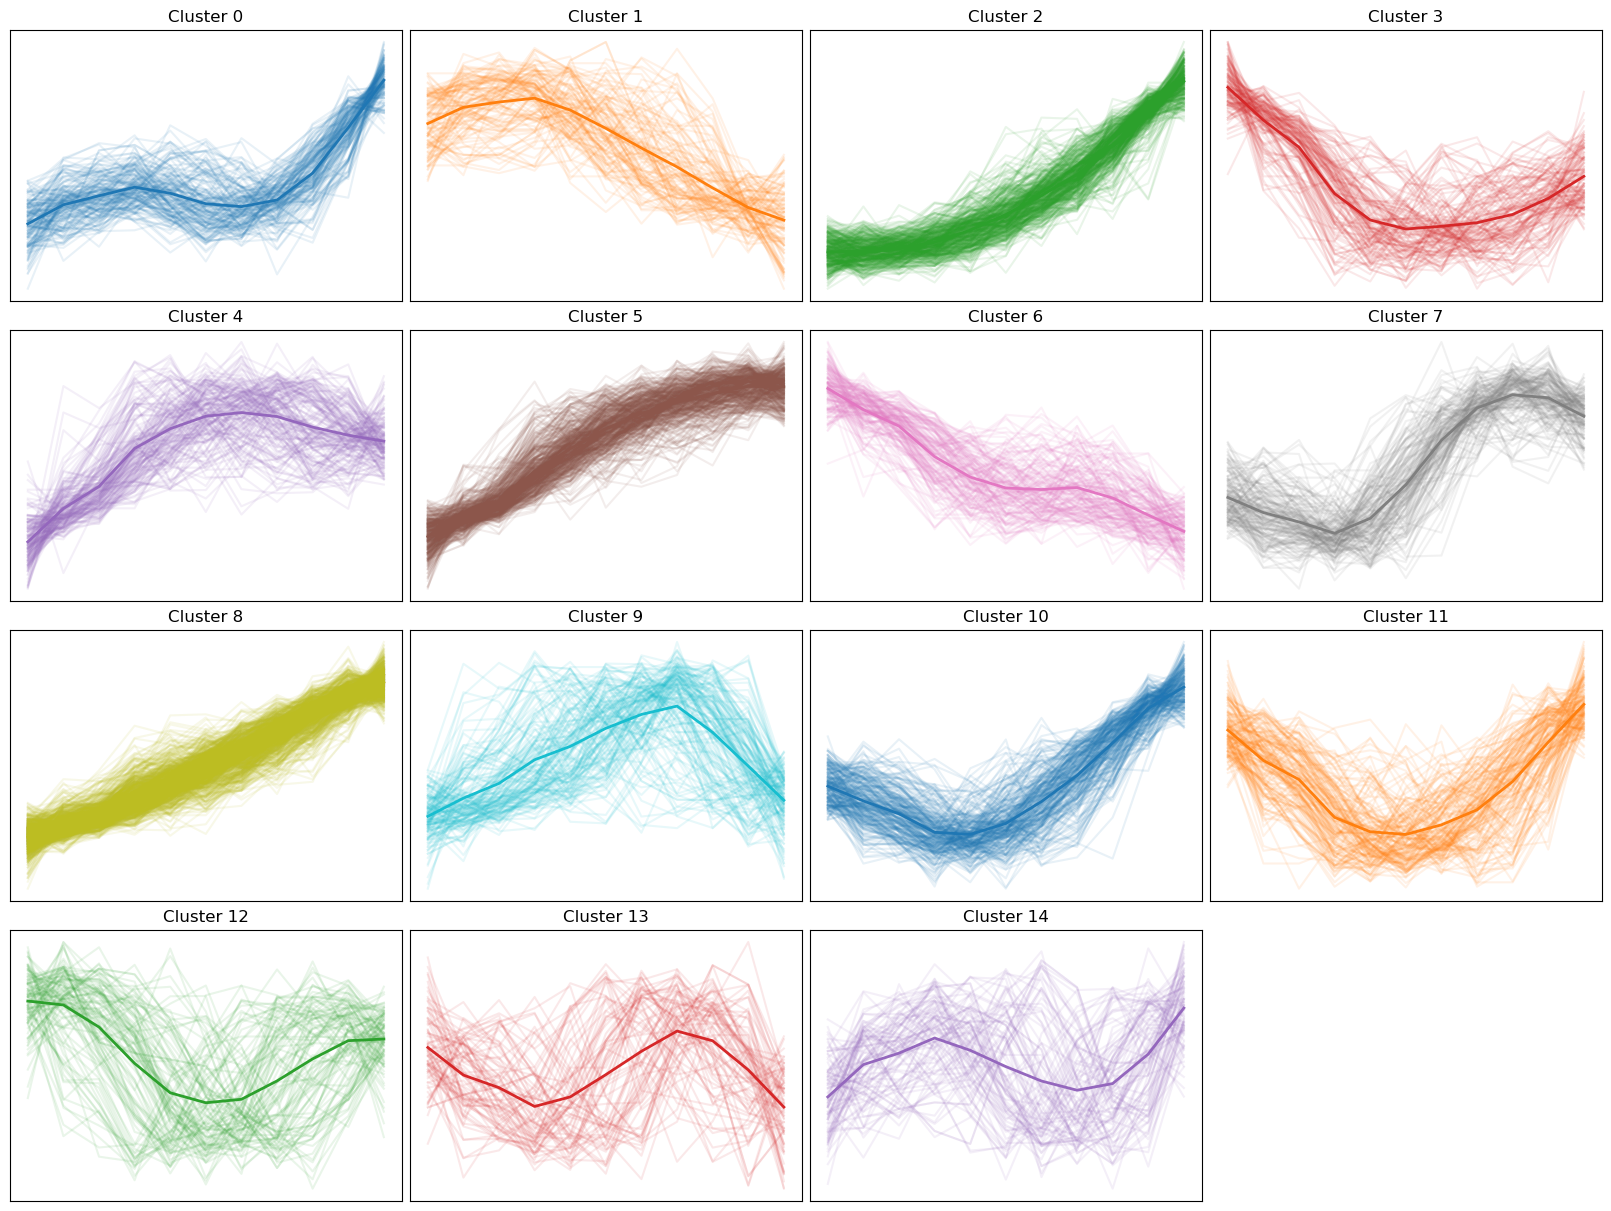

Displayed 15 out of 15 clusters.


In [502]:
import matplotlib.pyplot as plt
import math

clusters_to_display = 30 
clusters_to_display = min(clusters_to_display, n_clusters) 

columns = 4 
rows = math.ceil(clusters_to_display / columns)

fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 3), constrained_layout=True)

axes = axes.flatten()

for i, cluster_id in enumerate(range(clusters_to_display)):
    ax = axes[i]

    cluster_data = normalized_data_array[df["Cluster"] == cluster_id]

    mean_trend = cluster_data.mean(axis=0).ravel()

    for series in cluster_data:
        ax.plot(series.ravel(), color=f"C{cluster_id}", alpha=0.1)

    ax.plot(mean_trend, color=f"C{cluster_id}", linewidth=2)

    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xticks([])  
    ax.set_yticks([]) 


for ax in axes[clusters_to_display:]:
    ax.axis("off")


plt.show()

print(f"Displayed {clusters_to_display} out of {n_clusters} clusters.")
